In [32]:
# TensorFlow提供了数据集读取方法

import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print('训练集数量：',mnist.train.num_examples,
      '验证集数量：',mnist.validation.num_examples,
      '测试集数量：',mnist.test.num_examples)

训练集数量： 55000 验证集数量： 5000 测试集数量： 10000


In [3]:
# 28*28=784, 10分类one hot编码
print('train images shape:', mnist.train.images.shape,
      'labels shape:', mnist.train.labels.shape)

train images shape: (55000, 784) labels shape: (55000, 10)


In [4]:
len(mnist.train.images[0])

784

In [5]:
# mnist.train.images[0].shape

In [6]:
# mnist.train.images[0]

In [7]:
# mnist.train.images[0].reshape(28,28)

## 显示图像

In [8]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.show()

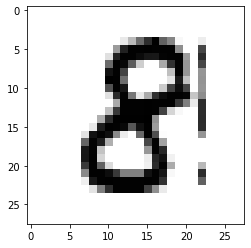

In [9]:
plot_image(mnist.train.images[9])

## 构建输入层

In [10]:
## 定义带输入数据的占位符
x = tf.placeholder(tf.float32, [None, 784], name='X')

y = tf.placeholder(tf.float32, [None, 10], name='Y')

## 构建模型


In [11]:
# 隐藏层神经元数量
H1_NN = 256 # 第1隐藏层神经元为256个
H2_NN = 64  # 第2隐藏层神经元为64个

# 输入层——第1隐藏层参数和偏置项
# truncated_normal:阶段随机数生成，多层神经网络中建议使用阶段随机数生成
W1 = tf.Variable(tf.truncated_normal([784, H1_NN], stddev=0.1))
b1 = tf.Variable(tf.zeros([H1_NN]))

# 第1隐藏层——第2隐藏层参数和偏置项
W2 = tf.Variable(tf.truncated_normal([H1_NN, H2_NN], stddev=0.1))
b2 = tf.Variable(tf.zeros([H2_NN]))

# 第2隐藏层——输出层参数和偏置项
W3 = tf.Variable(tf.truncated_normal([H2_NN, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))

# 计算第1隐藏层结果
Y1 = tf.nn.relu(tf.matmul(x, W1) + b1)

# 计算第2隐藏层结果
Y2 = tf.nn.relu(tf.matmul(Y1, W2) + b2)

# 计算输出结果
forward = tf.matmul(Y2, W3) + b3
pred = tf.nn.softmax(forward)

## 定义全连接层函数

In [12]:
def fcn_layer(inputs,       # 输入数据
              input_dim,    # 输入神经元数量
              output_dim,    # 输出神经元数量
              activation=None    # 激活函数
              ):
    # 以截断正态分布的随机树初始化W
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1))
       
    # 以0初始化b
    b = tf.Variable(tf.zeros([output_dim]))
    
    XWb = tf.matmul(inputs, W) + b # 建议表达式：inputs * W + b
    
    if activation is None:  # 默认不适用激活函数
        outputs = XWb
    else:                   # 若传入激活函数，则用其对输出结果进行变换
        outputs = activation(XWb)
        
    return outputs

## 训练模型

In [13]:
# 设置训练参数
train_epochs = 40 # 训练轮数
batch_size = 50 # 单次训练样本数
total_batch = int(mnist.train.num_examples/batch_size) # 一轮训练有多少批次
display_step = 1 # 显示粒度
learning_rate = 0.01 # 学习率

In [14]:
## 定义损失函数-交叉熵
# 使用结合softmax的交叉熵损失函数定义方法
# loss_function = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred),reduction_indices=1))
loss_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=forward, labels=y))
# 这里计算的损失函数的值是不做softmax的数据，经过softmax后，如果为0，会使计算结果发散

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
## 选择优化器-Adam优化器
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

In [16]:
## 定义准确率
## 检查预测类别tf.argmax(pred, 1)与实际类别tf.argmax(y, 1)的匹配情况
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y,1))

In [17]:
# 准确率，将布尔值转化为浮点数，并计算平均值
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 训练模型的保存

模型保存机制中，缺省最多保存最近5份模型

In [18]:
# 初始化参数和文件目录
# 存储模型的粒度
save_step = 5

# 创建保存模型文件的目录
import os

ckpt_dir = './ckpt_dir/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
# 训练并存储模型
# 声明完所有变量后，调用tf.train.Saver
saver = tf.train.Saver()

## 模型训练

In [19]:
# 记录训练开始时间
from time import time
startTime = time()

sess = tf.Session() # 声明会话
init = tf.global_variables_initializer() # 变量初始化
sess.run(init)

In [20]:
## 开始训练
for epoch in range(train_epochs):
    for batch in range(total_batch):
        xs, ys = mnist.train.next_batch(batch_size) # 读取批次数据
        sess.run(optimizer, feed_dict={x:xs, y:ys}) # 执行批次训练
        
    # total_batch个批次训练完成后，使用验证数据计算误差与准确率，验证集没有分批
    loss, acc = sess.run([loss_function, accuracy], 
                         feed_dict={x:mnist.validation.images, y:mnist.validation.labels})
    
    # 打印训练过程中的详细信息
    if(epoch+1) % display_step ==0:
        print('Train Epoch:', '%02d' % (epoch+1), 'loss=', '{:.9f}'.format(loss),\
             'Accuracy=', '{:.4f}'.format(acc))
    
    # 保存模型
    if(epoch+1) % save_step == 0:
        # 参数1：模型所有参数，参数2：保存目录
        saver.save(sess, os.path.join(ckpt_dir, 
                                      'mnist_h256_model_{:06d}.ckpt'.format(epoch+1))) #存储模型
        print('mnist_h256_model_{:06d}.ckpt saved'.format(epoch+1))

# 保存最终模型训练结果
saver.save(sess, os.path.join(ckpt_dir, 'mnist_h256_model.ckpt'))
print('Model saved!')

# 显示运行总时间
duration = time()-startTime
print('Train Finished takes:', '{:.2f}'.format(duration))

Train Epoch: 01 loss= 0.169140399 Accuracy= 0.9504
Train Epoch: 02 loss= 0.155493498 Accuracy= 0.9592
Train Epoch: 03 loss= 0.169679657 Accuracy= 0.9608
Train Epoch: 04 loss= 0.161101177 Accuracy= 0.9554
Train Epoch: 05 loss= 0.154758677 Accuracy= 0.9642
mnist_h256_model_000005.ckpt saved
Train Epoch: 06 loss= 0.150445566 Accuracy= 0.9686
Train Epoch: 07 loss= 0.154603347 Accuracy= 0.9680
Train Epoch: 08 loss= 0.155777395 Accuracy= 0.9702
Train Epoch: 09 loss= 0.160262972 Accuracy= 0.9650
Train Epoch: 10 loss= 0.184112787 Accuracy= 0.9660
mnist_h256_model_000010.ckpt saved
Train Epoch: 11 loss= 0.153630078 Accuracy= 0.9712
Train Epoch: 12 loss= 0.177317142 Accuracy= 0.9672
Train Epoch: 13 loss= 0.185638577 Accuracy= 0.9678
Train Epoch: 14 loss= 0.179568723 Accuracy= 0.9746
Train Epoch: 15 loss= 0.187161475 Accuracy= 0.9716
mnist_h256_model_000015.ckpt saved
Train Epoch: 16 loss= 0.187203899 Accuracy= 0.9730
Train Epoch: 17 loss= 0.181221053 Accuracy= 0.9722
Train Epoch: 18 loss= 0.1807

## 评估模型

### 完成训练后，在测试集上评估模型的准确率

In [21]:
accu_test = sess.run(accuracy, 
                     feed_dict={x:mnist.test.images, y:mnist.test.labels})

print('Test Accuracy:', accu_test)

Test Accuracy: 0.9676


### 完成训练后，在验证集上评估模型的准确率

In [22]:
accu_validation = sess.run(accuracy, 
                     feed_dict={x:mnist.validation.images, y:mnist.validation.labels})

print('Validation Accuracy:', accu_validation)

Validation Accuracy: 0.9724


### 完成训练后，在训练集上评估模型的准确率

In [23]:
accu_train = sess.run(accuracy,
                     feed_dict={x:mnist.train.images, y:mnist.train.labels})
print('Train Accuracy:', accu_train)

Train Accuracy: 0.98867273


多层效果不一定比单层网络效果好！

## 模型应用

### 在建立模型并进行训练后，若认为准确率可以接受，则可以使用此模型进行预测

In [24]:
# 由于pred预测结果是one-hot编码格式，所以需要转换为0~9数字
prediction_result = sess.run(tf.argmax(pred, 1),
                             feed_dict={x:mnist.test.images})

In [25]:
# 查看预测结果中的前10项
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

## 可视化预测结果

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_labels_prediction(images,# 图像列表
                                  labels, # 标签列表
                                  prediction, # 预测值列表
                                  index, # 从第index个开始显示
                                  num=10):# 缺省一次显示10幅
    fig = plt.gcf() # 获取当前图表
    fig.set_size_inches(10, 12) # 1英寸等于2.54cn
    if num > 25:
        num = 25 #最多显示25个子图
        
    for i in range(0, num):
        ax = plt.subplot(5,5,i+1) # 获取当前要处理的子图
        ax.imshow(np.reshape(images[index], (28, 28)), # 显示第index个图像
                 cmap='binary')
        
        title = 'label=' + str(np.argmax(labels[index])) # 构建该图上要显示的title
        if len(prediction)>0:
            title += ',prediction=' + str(prediction[index]) 
        
        ax.set_title(title, fontsize=10) # 显示图上的title信息
        ax.set_xticks([])
        ax.set_yticks([])
        index +=1
        
    plt.show()

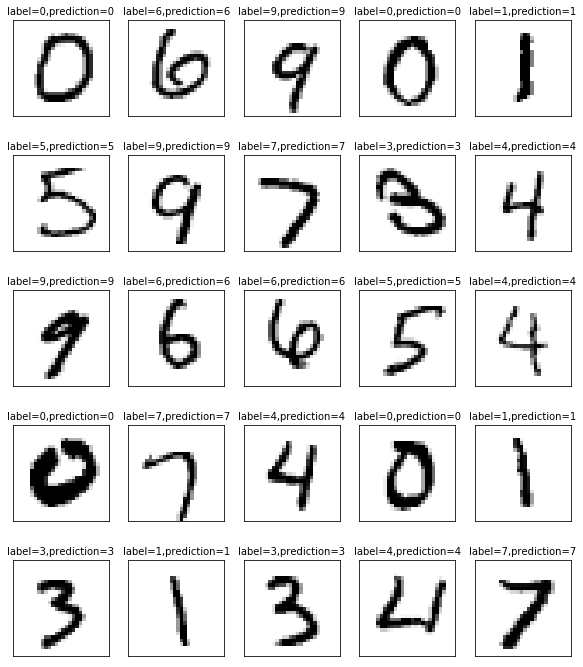

In [27]:
plot_images_labels_prediction(mnist.test.images,
                              mnist.test.labels,
                              prediction_result, 10, 25)

## 找出预测错误的样本

In [28]:
compare_lists = prediction_result==np.argmax(mnist.test.labels, 1)
print(compare_lists)

[ True  True  True ...  True  True  True]


In [29]:
err_lists = [i for i in range(len(compare_lists)) if compare_lists[i]==False]
print(err_lists, len(err_lists))

[149, 175, 217, 247, 259, 320, 321, 340, 445, 447, 448, 449, 456, 495, 551, 582, 583, 610, 619, 659, 667, 684, 717, 720, 839, 877, 882, 924, 951, 956, 965, 969, 1014, 1032, 1039, 1044, 1112, 1114, 1156, 1178, 1181, 1182, 1226, 1232, 1241, 1242, 1247, 1260, 1282, 1290, 1299, 1319, 1326, 1328, 1393, 1395, 1414, 1425, 1444, 1466, 1494, 1500, 1520, 1530, 1549, 1551, 1553, 1554, 1569, 1621, 1641, 1678, 1681, 1751, 1754, 1790, 1800, 1871, 1883, 1901, 1903, 1941, 1987, 2016, 2018, 2028, 2035, 2053, 2063, 2093, 2098, 2118, 2130, 2135, 2161, 2162, 2182, 2215, 2224, 2272, 2291, 2293, 2298, 2369, 2381, 2387, 2393, 2422, 2433, 2454, 2462, 2488, 2517, 2597, 2607, 2648, 2654, 2721, 2730, 2751, 2770, 2810, 2863, 2877, 2896, 2915, 2927, 2939, 2970, 2979, 2995, 3062, 3073, 3117, 3130, 3207, 3225, 3239, 3250, 3284, 3289, 3318, 3333, 3422, 3475, 3490, 3503, 3520, 3558, 3559, 3575, 3580, 3597, 3604, 3662, 3674, 3702, 3751, 3757, 3767, 3776, 3780, 3796, 3808, 3818, 3838, 3853, 3871, 3902, 3906, 3941, 3976,

## 定义一个输出错误分类的函数

In [30]:
def print_predict_errs(labels, prediction):
    count = 0
    compare_lists = (prediction==np.argmax(labels, 1))
    err_lists = [i for i in range(len(compare_lists)) if compare_lists[i]==False]
    for x in err_lists:
        print('index='+str(x)+
              '标签值=', np.argmax(labels[x]),
              '预测值=', prediction[x])
        count += 1
    print('总计：'+str(count))

In [31]:
print_predict_errs(labels=mnist.test.labels,
                  prediction=prediction_result)

index=149标签值= 2 预测值= 3
index=175标签值= 7 预测值= 3
index=217标签值= 6 预测值= 5
index=247标签值= 4 预测值= 6
index=259标签值= 6 预测值= 0
index=320标签值= 9 预测值= 3
index=321标签值= 2 预测值= 7
index=340标签值= 5 预测值= 3
index=445标签值= 6 预测值= 0
index=447标签值= 4 预测值= 9
index=448标签值= 9 预测值= 3
index=449标签值= 3 预测值= 5
index=456标签值= 2 预测值= 3
index=495标签值= 8 预测值= 3
index=551标签值= 7 预测值= 3
index=582标签值= 8 预测值= 2
index=583标签值= 2 预测值= 3
index=610标签值= 4 预测值= 3
index=619标签值= 1 预测值= 8
index=659标签值= 2 预测值= 3
index=667标签值= 7 预测值= 3
index=684标签值= 7 预测值= 3
index=717标签值= 0 预测值= 3
index=720标签值= 5 预测值= 8
index=839标签值= 8 预测值= 3
index=877标签值= 8 预测值= 3
index=882标签值= 9 预测值= 7
index=924标签值= 2 预测值= 3
index=951标签值= 5 预测值= 3
index=956标签值= 1 预测值= 3
index=965标签值= 6 预测值= 3
index=969标签值= 4 预测值= 9
index=1014标签值= 6 预测值= 5
index=1032标签值= 5 预测值= 3
index=1039标签值= 7 预测值= 3
index=1044标签值= 6 预测值= 3
index=1112标签值= 4 预测值= 6
index=1114标签值= 3 预测值= 8
index=1156标签值= 7 预测值= 3
index=1178标签值= 4 预测值= 3
index=1181标签值= 6 预测值= 1
index=1182标签值= 6 预测值= 8
index=1226标签值= 7 预测值= 2
